Notes
- Heart Rate Variability (HRV) represents the fluctuations between two consecutive beats in the heart rate record.
- Heart Rate Variability (HRV) is based on the estimation of the distance between two consecutive beats which often called NN intervals or RR intervals.  
- Variation in the heart rate can be evaluated using two main methods: time-domain and Frequency domain. 
- Some of these measures are derived from direct estimation of the RR interval. Others are derived from the differences between RR intervals.
- Many of the measures correlate closely with others.
- The method selected should correspond to the aim of each study.
- The key part before applying any of these methods is to accurately estimate the RR intervals for a given signal. 

For references: 
- Malik, M., Bigger, J. T., Camm, A. J., Kleiger, R. E., Malliani, A., Moss, A. J., & Schwartz, P. J. (1996).  Heart rate variability: Standards of measurement, physiological interpretation, and clinical use.  European heart journal, 17(3), 354-381.
-  An Efficient Algorithm for Automatic Peak Detection in Noisy Periodic and Quasi-Periodic Signals.
- https://github.com/rhenanbartels/hrv
- This code was written by Abdulrahman Alkurdi, adapted from Ahmed Algaraawi's in addition to biosppy package. 

In [1]:
# Computation & Signal Processing
from scipy import signal
import numpy as np
import pandas as pd
import pylab as pl
import pickle

#biosppy package for ecg signal analysis
from biosppy import storage
from biosppy.signals import ecg

# Plotting
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.io as pio
plotly.offline.init_notebook_mode(connected=True)
%matplotlib widget

from utils import * #import data import, clean up and sampling functions. 
# import time
import time

from ECG_feature_extractor_1000 import *


ModuleNotFoundError: No module named 'biosppy'

# Reading data

In [23]:
# fs: sampling frequency
# df: reading a csv file and store it in panads dataframe (http://pandas.pydata.org/pandas-docs/stable/)
fs = 1926  

data_dir = 'csv'
df = load_data('/OA_2019_302_P1_Rep_1.3.csv', data_dir)[1000:11000]

df = df.reset_index(drop=True)

In [24]:
# Select the ecg signal in the df dataframe.
print ('Total number of samples:', df.shape[0])
print ('In time scale:', df.shape[0]/(fs*60), 'mins')
print ('In time scale:', df.shape[0]/(fs), 'secs')

Total number of samples: 10000
In time scale: 0.08653513326410522 mins
In time scale: 5.192107995846314 secs


In [25]:

# data clean up and assignment
p1 = ecg_clean_up(df)
p1.fs = fs

end = time.time()

# p1.ecg contains the ecg signal while p1.time contains the time. p1.fs contains sampling frequency. 

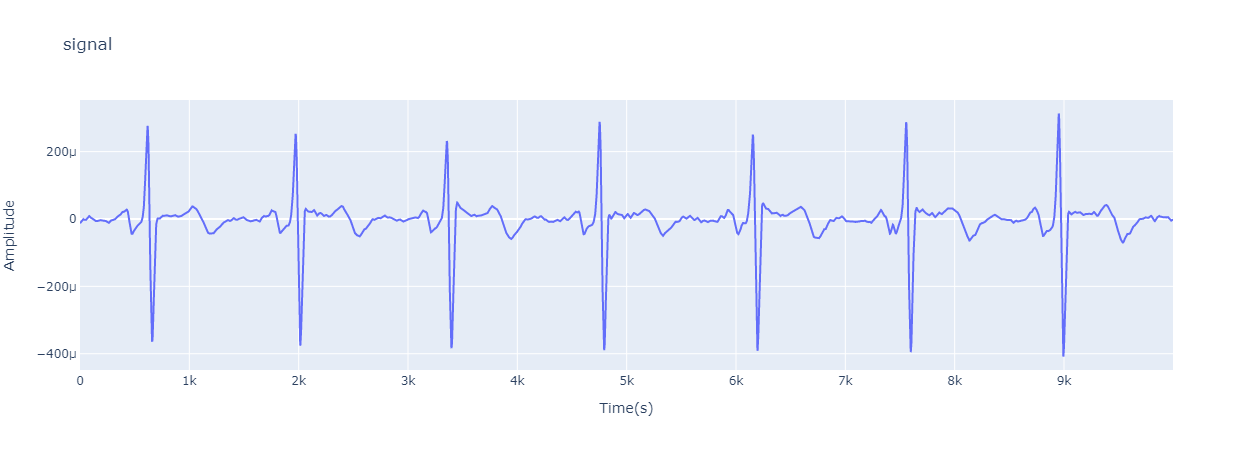

In [26]:
# plot the ecg signal
# Here I'm using plotly which provides zooming feature (https://plot.ly/python)
trace1 = go.Scatter(
    x = p1.ecg.index,
    y = p1.ecg,
    mode = 'lines'
)

layout = go.Layout(
    title='signal',
    xaxis=dict(title= 'Time(s)'),
    yaxis=dict(title= 'Amplitude'),
)

data = [trace1]
fig= go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)


In [41]:
#this loop controls which peak detection method. At false is disables the scalogram method for RR detection. 
hybrid = True
if not hybrid:
    ## Initialization
    # N: total No. of samples
    # L: number of scales
    # alpha: constant factor 
    # M: Local Maxima Scalogram matrix (initialize with random numbers)
    # M_reshaped: Local Maxima Scalogram matrix, reshaped to the scales of interest.

    N =  ecg.shape[0]                           
    L = int(2*fs)       
    alpha =10;                                
    M = alpha + np.abs(np.random.randn(L,N))
    M_reshaped =0

    print ('N = ', N)
    print ('L = ', L)
    print ('M = ', M.shape)# L: number of scales
    # k: scale (frequency resolution)
    for k in range(0, int(L)): 
        start = time.time()
        for i in range(k+1, N-k-1):
            if (ecg[i]>ecg[i-k-1] and ecg[i]>ecg[i+k+1]):
                M[k,i]=0;

    # gamma: array of shape L. 
    #        by summing all the columns, you get a vector that contains 
    #        the information about the scale-dependant distribution of zeros (local maxima)
    # chosen: number of chosen scales (rows), which is index of the global minimum 
    #         This represents the scale with the most local maxima.

    gamma = np.sum(M, axis=1)
    chosen = np.argmin(gamma)
    print ('number of chosen rows = ', chosen)

    plt.figure(figsize=(8,4))
    plt.plot(gamma)
    plt.title('Finding the scale (row) which holds the global minimum')
    plt.ylabel('value of the resulted row-wise sum')
    plt.xlabel('scales (L)')
    plt.show()

    # M_reshaped: Local Maxima Scalogram matrix, reshaped to the scales of interest.
    # standard: shape N 
    #           the standard deviation of the reshaped M matrix in the x-axis.

    M_reshaped = M[0:chosen,:]
    standard = np.std(M_reshaped, axis=0)


    # peakLocations: ecg peaks locations in samples.
    # peakLocations_time: ecg peaks locations in time (s)
    # RR intervals in ms

    peakLocations = np.where(standard==0)[0]
    peakLocations_time = peakLocations/fs;
    RR = np.diff(peakLocations_time) * 1000;
    # For better visualization, slice the M matrix up to some sample.
    sample = 1000
    ax =plt.figure(figsize=(8,8))
    plt.imshow(M_reshaped[:,:sample], aspect=sample/100);
    plt.title('Local Maxima Scalogram matrix (LMS)')
    plt.ylabel('scale (k)')
    plt.xlabel('sample')
else:
    # We perform analysis on the waveforms to obtain RR peaks. 
    BS_signal_analysis = ecg.ecg(signal=p1.ecg, sampling_rate=p1.fs, show=True)
    peakLocations = BS_signal_analysis['rpeaks']
peakLocations_time = peakLocations/fs;
RR = np.diff(peakLocations_time) * 1000;

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

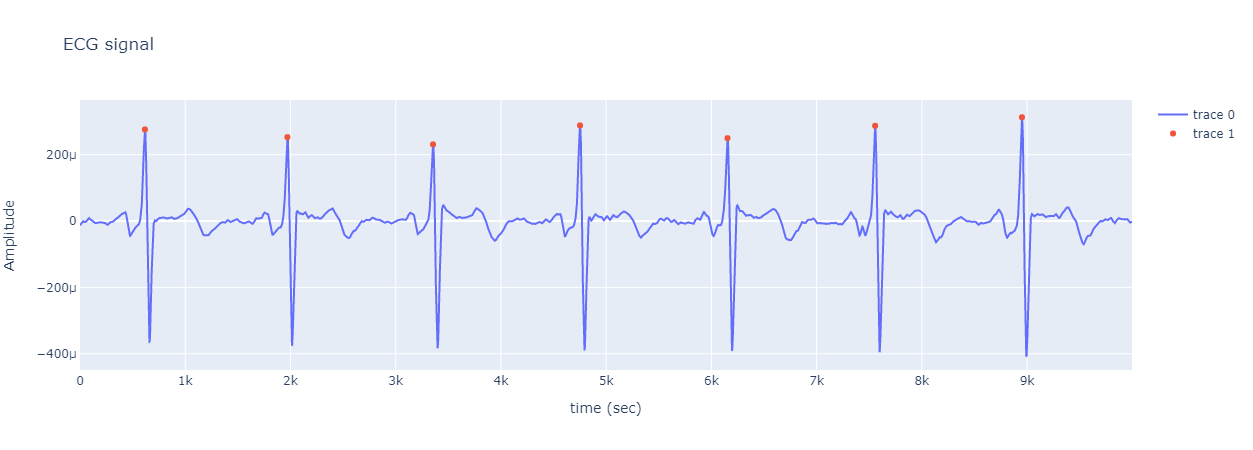

In [39]:
# plot the ecg signal with the peaks locations. (again: using plotly library)
trace1 = go.Scatter(
    x = np.arange(p1.ecg.shape[0]),
    y = p1.ecg,
    mode = 'lines'
)
trace2 = go.Scatter(
    x = peakLocations,
    y = p1.ecg[peakLocations],
    mode = 'markers'
)
layout = go.Layout(
    title='ECG signal',
    xaxis=dict(title= 'time (sec)'),
    yaxis=dict(title= 'Amplitude'),
)

data = [trace1,trace2]

fig= go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)


In [45]:
bands = {'vlf': (0, 0.04), 'lf': (0.04, 0.15), 'hf': (0.15, 0.4)}

#this external function performs the frequency analysis. 
pack,  ecg_out = freq_ratio_hybrid(p1.ecg, fs=p1.fs, RR=BS_signal_analysis['rpeaks'], method = 'periodogram', factor = 1)
#pack contains the frequency domain metrics while ecg_out outputs the altered ecg signal (after filtering or resampling, if any)